# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [1]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.reconstruction.least_squares import LeastSquaresSolver
from thick_ptycho.utils.visualisations import Visualisation

import numpy as np

import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_results = "./results"
results_dir = os.path.join(base_results, timestamp)
os.makedirs(results_dir, exist_ok=True)

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe

# Constants
wavelength = 0.635e-6   # meters
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# Background refractive index
nb = 1.0  # soft tissue approx. in vacuum

# Refractive index perturbation for soft tissue
delta = 0.01
beta = 0.001
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0.0, 150e-6]   # meters (sample width)
zlims = [0.0, 150e-6]   # meters (sample thickness)
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)  
print(f"{nz=}")

# Discrete space parameters
probe_dimensions = [40]             # Discrete Probe dimensions
probe_diameter = int(0.8 * min(probe_dimensions))
scan_points = 124  # image planes
step_size = 3   

probe_angles_list = [0.0]               # Step size in pixels
probe_focus =  -0.00001 # focal length [m]

# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"{min_nx=}")
# Number of pixels in x directions
nx= nz
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    nz
    ]   

nz=472
min_nx=412


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [3]:
sample_space = SampleSpace(
    continuous_dimensions,   # meters
    discrete_dimensions,     # pixels (nx, nz)
    probe_dimensions,        # detector/probe window (pixels)
    scan_points,             # number of scan positions
    step_size,
    bc_type,                 # impedance / dirichlet / neumann
    probe_type,
    k0,                      # wavenumber [1/m]
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,        
    n_medium=nb,
)

sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space,results_dir=results_dir)

2025-10-08 14:37:39,133 - INFO - === Scan Summary (Continuous) ===
2025-10-08 14:37:39,134 - INFO -   Sample space (x-range): 1.500e-04 m
2025-10-08 14:37:39,135 - INFO -   Sample space (z-range): 1.500e-04 m
2025-10-08 14:37:39,136 - INFO -   Probe diameter:         1.019e-05 m
2025-10-08 14:37:39,137 - INFO -   Number of scan points:  124
2025-10-08 14:37:39,137 - INFO -   Steps in z:             472
2025-10-08 14:37:39,138 - INFO -   Detector Pixels:        472
2025-10-08 14:37:39,138 - INFO -   Max Overlap:            9.236e-06 m
2025-10-08 14:37:39,139 - INFO -   Percentage Overlap:     90.62%



In [4]:
import numpy as np
gaussian_blur = 3

# Add 6 spheres of varying diameters and positions
common_side_length = 0.05*xlims[1]  # μm diameter
common_depth = 0.05*zlims[1]  # μm depth

sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
                        centre=(100/300*xlims[1], 100/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(150/300*xlims[1], 200/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(220/300*xlims[1], 200/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(125/300*xlims[1], 150/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(175/300*xlims[1], 100/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(100/300*xlims[1], 220/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


2025-10-08 14:38:28,032 - INFO - Initializing Least Squares Solver...
2025-10-08 14:38:28,041 - INFO - Solving the true forward problem to generate the dataset...
2025-10-08 14:38:30,366 - INFO - Plot True Object
2025-10-08 14:38:33,531 - INFO - True Forward Solution computed in 5.49 seconds.
2025-10-08 14:38:33,532 - INFO - Angle 0.0


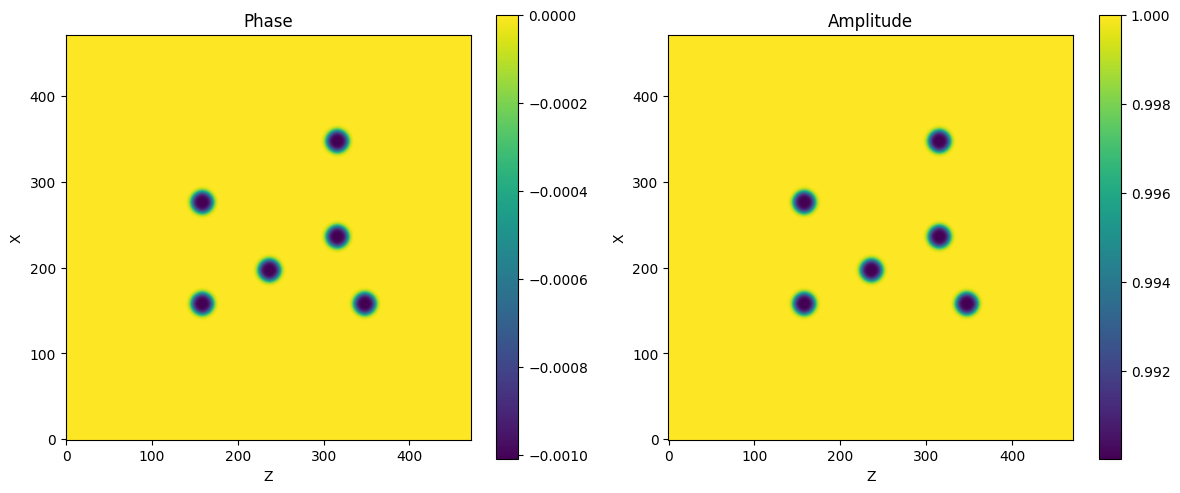

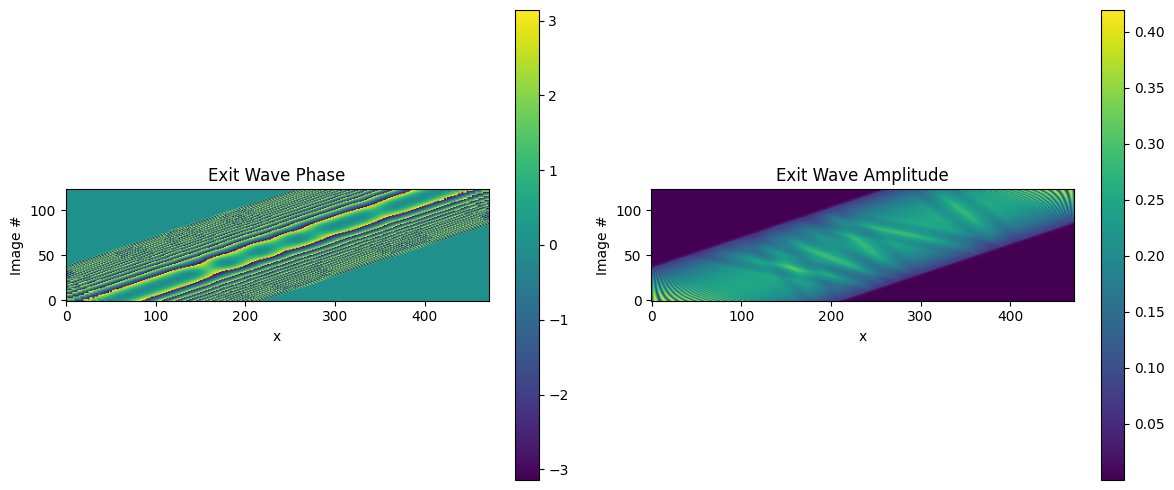

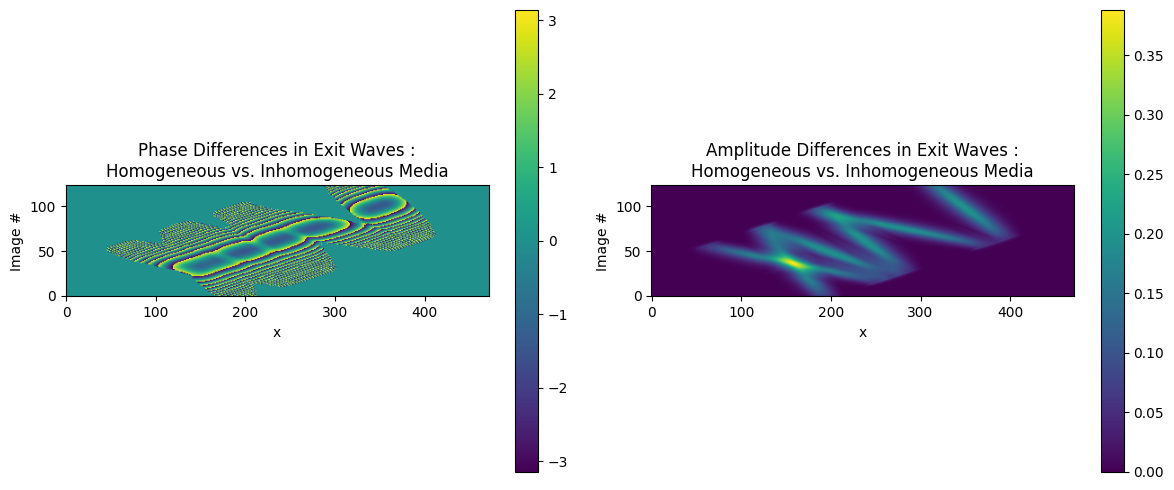

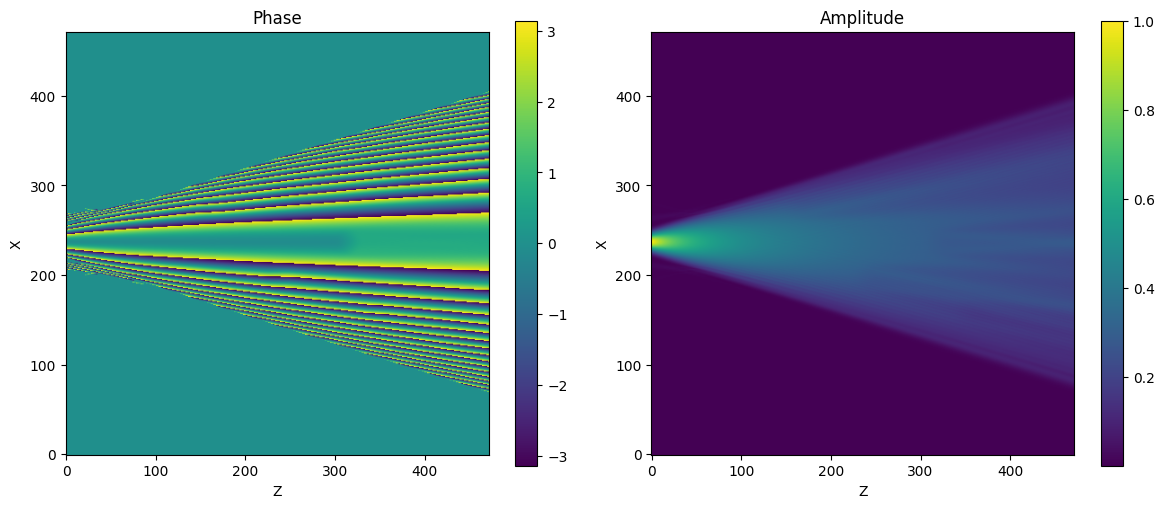

In [7]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=False,probe_angles_list=probe_angles_list,results_dir=results_dir)

In [ ]:
max_iters = 3
reconstructed_refractive_index, reconstructed_forward_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=False,
                        plot_reverse=False,
                        plot_object=False,
                        plot_gradient=False,
                        solve_probe=False,
                        sparsity_lambda=0.0,
                        low_pass_filter=0.0)
)

2025-09-19 15:01:48,887 - INFO - Iteration 1/3
2025-09-19 15:01:48,888 - INFO -     RMSE: 0.06286733273668983
2025-09-19 15:02:00,403 - INFO -     Iteration 1 took 16.26 seconds.
2025-09-19 15:02:04,793 - INFO - Iteration 2/3
2025-09-19 15:02:04,794 - INFO -     RMSE: 0.04970642526604964
2025-09-19 15:02:16,641 - INFO -     Iteration 2 took 16.24 seconds.
2025-09-19 15:02:21,109 - INFO - Iteration 3/3
2025-09-19 15:02:21,109 - INFO -     RMSE: 0.04302717053293315
2025-09-19 15:02:32,954 - INFO -     Iteration 3 took 16.31 seconds.


### 7. Visualise the Residual History and Final Iterations

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Residual History of Least Squares Objective Function'}, xlabel='Iteration', ylabel='RMSE'>)

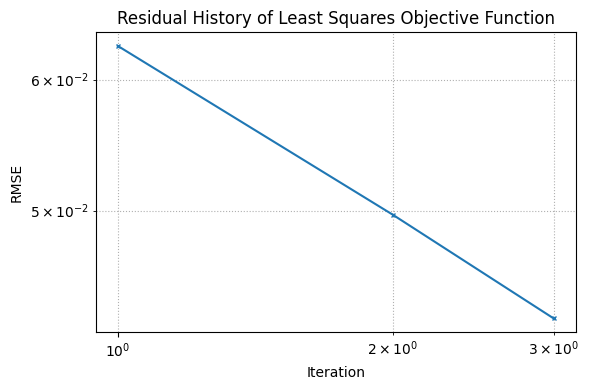

In [ ]:
visualisation.plot_residual(residual_history)

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: title={'center': 'Phase of Reconstructed Sample Space'}, xlabel='z (pixels)', ylabel='x (pixels)'>,
        <Axes: title={'center': 'Amplitude of Reconstructed Sample Space'}, xlabel='z (pixels)', ylabel='x (pixels)'>],
       dtype=object))

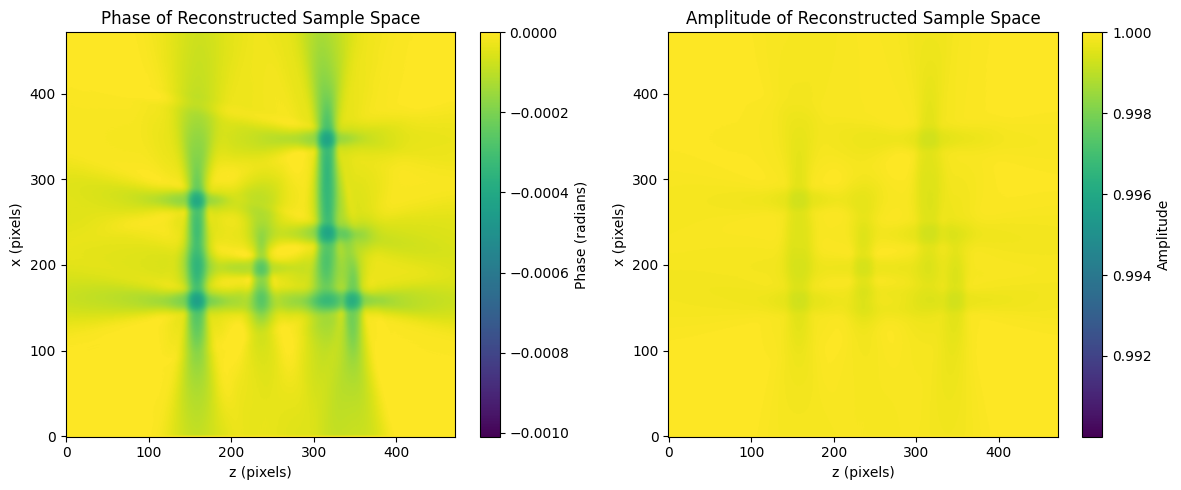

In [ ]:
visualisation.plot_refractive_index(reconstructed_refractive_index,
                                    title="Reconstructed Sample Space")

(<Figure size 1200x500 with 4 Axes>,
 (<Axes: title={'center': 'reconstructed_forward_wave Phase'}, xlabel='Z', ylabel='X'>,
  <Axes: title={'center': 'reconstructed_forward_wave Amplitude'}, xlabel='Z', ylabel='X'>))

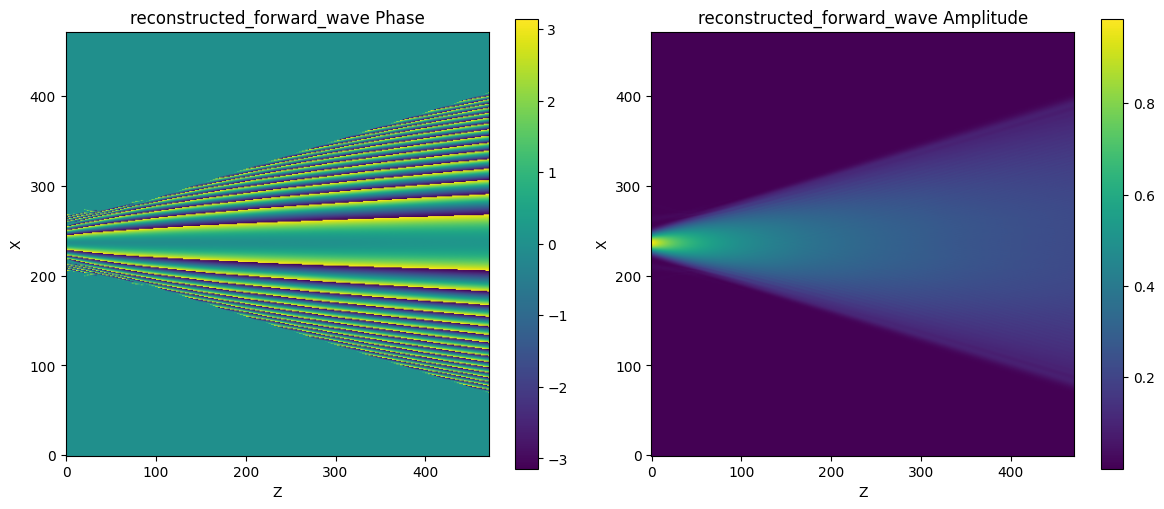

In [ ]:
visualisation.plot_auto(reconstructed_forward_wave[0], view="phase_amp", layout="single",title_prefix="reconstructed_forward_wave ")